<a href="https://www.kaggle.com/code/nghtctrl/modeling-revision-classification?scriptVersionId=174998627" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Modeling Revision Classification

Daniel Kim\*, Jason G. Chew\*, [Jiho Kim](https://jihokim.dev/)\*

*Equal Contribution

# Introduction

In the writing process, effective textual revisions typically result in expansive alterations to the semantic content of a text, as opposed to prescriptive alterations like proofreading; however, novice writers often tend to favor the latter ([Flower et. al 1986](https://doi.org/10.2307/357381)). Therefore, the identification of major semantic alterations in the revisions of student writers could be used to benchmark their progress towards more effective revision. 

To this end, the following report analyzes various applications of language models towards revision evaluation, which is in this case framed as a binary classification task for identifying revisions as “content” (substantive) or “surface” (superficial) revisions. 

(Note: this report uses “content/substantive” and “surface/superficial” interchangeably.)

## Project Objectives and Approaches

This report measures the effectiveness of two approaches to the binary classification task:

1. Completion prompting: when given a “fill-in-the-blank” classification prompt like “...the revision is _________”, a language model can implicitly make predictions thanks to the logprobs, or “likelihoods,” it computes for each of the two possible classification terms (“substantive” and “superficial”). Once the model computes these likelihoods, they may be compared with one another to make the classification.

2. Similarity scores: a language model can compute abstract representations (embeddings) of an original and revised text based on their semantic content, and the similarity of those semantic embeddings can be used as a measure of how little a revision changed the “content” of a sentence; these similarities can then be used to predict whether a revision alters a sentence’s semantic meaning significantly enough to be considered a “content” revision.

## Summary of Results

When using completion prompting, performance on the task somewhat improved after preprending contextual information to the prompts, such as example classifications and definitions of the terms.

When switching the model used from GPT-2 to GEMMA, performance on the baseline prompt dropped to worse than random classification, demonstrating that prompts may not work equally well across different models with different tokenization schemes.

When using similarity scores, performance on the task improved significantly from even the best-performing completion approach. It was also much more computationally efficient, as the model was not required to generate completions.

More detailed analysis of the various approaches follow.

---

# The Dataset
We use a dataset called “[ArgRewriteV2](https://argrewrite.cs.pitt.edu/)”, which contains essays written by students in response to a single prompt about the implications of self-driving cars. Each essay has three versions: the original draft, a revision, and a second revision. The second revisions were not made under experimentally constant circumstances, so we will only use the first revisions for our evaluation. 

The dataset contains essay-level, sentence-level, and subsentence-level data. This report only uses the sentence-level data. Our goal is to classify the sentence-level revisions into two categories: “superficial” and “substantive.” The “superficial” category corresponds to the revision categories “Word Usage” and “Conventions/Grammar/Spelling” in the dataset. The “substantive” category corresponds to the categories "Claim/Ideas," "Organization," "Warrant/Reasoning/Backing", "Rebuttal/Reservation," "Precision," and "General Content" in the dataset. (Unlike the original dataset’s authors, we placed "Organization" in the “substantive” category as an arguably significant change to a sentence.)

The sentences in the dataset were originally split across many .xlsx files, with one file for each essay, and the revised sentences were not originally paired with their original sentences; instead, the dataset used an “index” system identifying the positions of sentences between drafts. The process of wrangling the sentences into a single dataset of sentence pairs, dropping unneeded data, and converting the original dataset’s revision categories to the binary categories of “content” (substantive) and “surface” (superficial) is shown in the Appendix.

---

# Evaluation Methodology: ROC Curves and AUCs for a Model’s “Scores”
To compute how reliably a given model assigns higher scores to positive “content” revisions than to negative “surface” revisions, this report evaluates models using an ROC curve and the Area Under the Curve (AUC).

An ROC curve plots the trade-off between a model’s true positive prediction rates and its false positive prediction rates at various “threshold values.” For example, one point on the ROC curve might show that a model would achieve a very high true positive rate and a very high false positive rate when using a low scoring threshold (“barrier to entry”) to predict the positive class. A strong model will retain a high true positive rate and a low false positive rate for most thresholds, which would be reflected by a “higher” ROC curve.

The AUC is calculated by computing the area under the ROC curve from false positive rate 0 to false positive rate 1; it indicates the probability that a model would correctly score any given “content” revision higher than any given “surface” revision. A perfect model would have an AUC of 1.

To perform better than a random classifier, a model’s ROC curve should stay above a diagonal “base line” of equal true positive and false positive rates. This means the model should have a >0.5 AUC.

### ROC Curve Function
We write a function to compute and display the ROC curve, along with the area under it (AUC).

In [1]:
def plot_roc(actual_rev_types, scores, metric_label):
    fpr, tpr, thresholds = roc_curve(actual_rev_types, scores, pos_label="content")
    # Plot code generated by ChatGPT:
    # https://chat.openai.com/share/2cb2a8d8-7d8e-46bf-b9b3-560db72f3f49
    roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
    fig = px.line(roc_df, x="fpr", y="tpr",
                  title=f"ROC Curve for {metric_label}",
                  labels={
                    "fpr": "False Positive Rate",
                    "tpr": "True Positive Rate",
                    "threshold": "Threshold",
                  },
                  hover_data={"threshold"}) 

    # Add a diagonal line (random classifier baseline)
    fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='gray', dash='dash'), name='Random Classifier')

    # Show the plot
    fig.show()
    
    # Calculate area under the ROC curve
    binary_rev_labels = [1 if label == "content" else 0 for label in actual_rev_types]
    auc = roc_auc_score(binary_rev_labels, scores)
    print("Area under the ROC Curve:", auc)

---

# Code Setup

In [2]:
%pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import json
import plotly.express as px
import pandas as pd
import torch

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {torch_device}")

torch.manual_seed(0);

Using device: cuda


---

## Load Data

In [4]:
data = pd.read_csv("/kaggle/input/argrewrite-v-2-corpus-sentence-pairs/sentence_pairs.csv")

In [5]:
actual_rev_types = []

for i in range(len(data)):
    revision_type = data.loc[i, "revision_type"]
    if revision_type != "neither":
        actual_rev_types.append(revision_type)

---

# Modeling the Prefix/Completion Approach

The **prefix/completion** approach to binary classification uses traditional left-to-right language modeling to make the classifications. To put it simply, such language models compute probabilities for all the words (**completions**) that might follow some prior context (**prefixes**). Thus, we use the model’s predicted probabilities for our specific class terms (“substantive” and “superficial”) to make classifications. This is accomplished by computing how much more likely a model would be to use the words “is substantive” than “is superficial” to describe a revision.


## The Prefix/Completion Classification Algorithm

The classification algorithm has the following general structure, with some variations in the prefix:

(**Definitional note**: “The sum of logprobs for a completion” is semantically similar to “the conditional probability of a completion.” However, logprobs are easier for computers to do math with, so we use logprobs instead of probabilities.)

1. Set prefix = **“The following revision from \<original sentence> to \<revised sentence>”**
2. Compute the sum of logprobs for the completion **“is substantive”.**
3. Compute the sum of logprobs for the completion **“is superficial”.**
4. If the logprob_sum(“is substantive”) - logprob_sum(“is superficial”) > a certain threshold, predict “content.” Else, predict “surface.”


## The Scoring Metric for Completions: Difference of Logprobs

Using the algorithm above, our “score” for the “positive class” (content-level revision) is computed by “the difference of logprobs” between the words “is substantive” and the words “is superficial,” i.e., “how much more likely the model is to describe the revision as ‘is substantive’ than ‘is superficial.’”

To this effect, we write a function that returns the logprobs of a completion given a prefix.

### Using Logprobs Instead of Loss
This report’s original classification algorithm scored the positive “content” class by using the losses (i.e. the model’s “surprisal”) on the prefixes *and* completions combined. This placed undue weight on the prefixes, whose expectedness should not have been factored into scoring the completions. This also unnecessarily increased computation time; hence, we elected to use logprobs of *only the completion* to score the “content” class instead.


## Logprob Function

In [6]:
def get_completion_logprobs(prefix, completion):
    with torch.no_grad():
        completion_ids = tokenizer.encode(completion, return_tensors="pt").to(torch_device)
        completion_len = completion_ids.shape[1]

        whole_phrase = prefix + completion
        whole_phrase_ids = tokenizer.encode(whole_phrase, return_tensors="pt").to(torch_device)
        whole_phrase_logits = model(whole_phrase_ids).logits
        whole_phrase_logprobs = torch.log_softmax(whole_phrase_logits[0], 1)

        completion_logprobs = []
        for i in range(-completion_len-1, -1):
            token_id = whole_phrase_ids[0][i+1]
            logprob = whole_phrase_logprobs[i][token_id]
            completion_logprobs.append(logprob)

    return completion_logprobs

## The Completion-Classifying Models

### Model 1: GPT-2
We will use GPT-2 as our baseline model for the completion prompting approach. GPT-2 is an older model from 2019 which at the time of its publishing significantly advanced the possibility of “competent generalists” for NLP tasks beyond “narrow expert[]” systems ([Radford et. al 2019](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)). We use the smaller 137-million parameter version of this model to reduce the compute power and time required to make a prediction, as we will be making many predictions over the course of this report. As one of the first language models that marked significant progress towards “competent generalist” performance, GPT-2 is a fitting model to use as a baseline to determine how such language models might perform on our specific classification task. 

### A Brief Consideration of XLNet (Not Used)
[XLNet](https://huggingface.co/docs/transformers/main/en/model_doc/xlnet), another model from 2019, demonstrated similar promise in a variety of NLP tasks. As opposed to GPT-2’s usage of left-to-right inference for generative applications, however, XLNet takes bidirectional context into account, which could feasibly help it gain a greater “understanding” of revisions than GPT-2. Since the primary concern of this report is classification rather than generation, XLNet could reasonably be applied to the classification task; however, its usage would likely require an approach other than “prefix/completion” to be effective, since it was not explicitly trained for “left-to-right” completion in the same manner as GPT-2.

### Model 2: GEMMA-2b
To get an idea of how a different model might change performance on a prompt, we will use GEMMA-2b for comparison. GEMMA is a much newer model with many more parameters (albeit quantized, in our case), so we might expect it to perform even better as a “competent generalist” than GPT-2. This difference should help us get an idea of if or how performance on a prompt scales with more “advanced” models.


## Using GPT-2


### Load GPT-2

In [7]:
model_name = "openai-community/gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=torch_device)

# Add the EOS token as PAD token
if model.generation_config.pad_token_id is None:
    model.generation_config.pad_token_id = model.generation_config.eos_token_id

tokenizer.decode([tokenizer.eos_token_id]);

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

2024-05-01 03:42:40.744029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 03:42:40.744148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 03:42:40.845374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## GPT-2 Baseline Prefix

Our baseline prefix for comparison with more advanced prefixes and with GEMMA is written as follows:

"The following revision from:\
\<original sentence>
to:\
\<revised sentence>\
"

The possible completions we ask the models to score are:

“is substantive” [content-level]\
“is superficial” [surface-level]

## Performance Analysis

In [8]:
# Build the prefixes

prompts = []

for i in range(len(data)):
    revision_type = data.loc[i, "revision_type"]
    if revision_type != "neither":
        old_sentence = data.loc[i, "original_sentence"]
        new_sentence = data.loc[i, "revised_sentence"]
        prompt = f"The following revision from: \n{old_sentence}\nto:\n{new_sentence}\n "
        prompts.append(prompt)

In [9]:
# Get GPT-2's predictions

shortening_factor = 1

gpt2_preds = []
gpt2_logprob_diffs = []

logprob_threshold = 0

for i in range(len(prompts)//shortening_factor):
    prompt = prompts[i]

    content_logprobs = torch.stack(get_completion_logprobs(prefix=prompt, completion="is substantive")).to(torch_device)
    surface_logprobs = torch.stack(get_completion_logprobs(prefix=prompt, completion="is superficial")).to(torch_device)

    logprob_diff = (torch.sum(content_logprobs) - torch.sum(surface_logprobs)).item()
    gpt2_logprob_diffs.append(logprob_diff)

    if logprob_diff > logprob_threshold:
        gpt2_preds.append("content")
    else:
        gpt2_preds.append("surface")

In [10]:
plot_roc(actual_rev_types[:len(prompts)//shortening_factor], gpt2_logprob_diffs, metric_label="Logprob Diff (GPT-2 Baseline)")

Area under the ROC Curve: 0.5815466163555915


We observe that GPT-2 performs better than the random classifier overall, but not much better; a random classifier would have an AUC of 0.5, and GPT-2 has an AUC of 0.582 here. This means that, for the baseline prompt, GPT-2 would have only a 58.2% chance to correctly score any given “content” revision higher than any given “surface” revision.

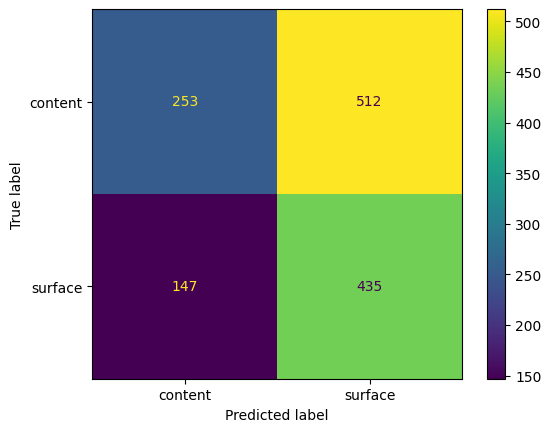

In [11]:
cm = confusion_matrix(actual_rev_types[:len(prompts)//shortening_factor], gpt2_preds, labels=["content", "surface"])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["content", "surface"]
)
disp.plot();

Using a threshold of 0 (i.e. predicting “content” only if the “substantial” logprobs were greater than the “superficial” logprobs), we observe that GPT-2 is strongly biased towards “surface-level” revisions, though it does make more correct “content” predictions than incorrect “content predictions.”

## Prompt-Engineered Prefix 1: Defining Classifications

Our second prefix is dual: one prefix defines the word “substantive,” the other “superficial.” Each prefix is matched to its corresponding completion.

The prefix defining “substantive” is written as follows:

*“Substantive revisions change the meaning significantly, so the following revision from ‘\<old sentence>’ to ‘\<new sentence>’ ”*

The prefix defining “superficial” is written as follows:

*“Superficial revisions only change words without affecting the overall meaning, so the following revision from '\<old sentence>' to '\<new sentence>' “*

To make the classification, we compute the logprobs for "is substantive" following the “substantive definition” prefix and the logprobs for "is superficial" following the "superficial definition" prefix. We then compare the logprobs as before.

In this way, giving the model definitions of the classification terms may better inform its weighting of those classification terms.


In [12]:
# Build the prefixes with class definitions

descriptive_prompts = []

for i in range(len(data)):
    revision_type = data.loc[i, "revision_type"]
    if revision_type != "neither":
        old_sentence = data.loc[i, "original_sentence"]
        new_sentence = data.loc[i, "revised_sentence"]
        content_stmt = f"Substantive revisions change the meaning significantly, so the following revision from '{old_sentence}' to '{new_sentence}' "
        surface_stmt = f"Superficial revisions only change words without affecting the overall meaning, so the following revision from '{old_sentence}' to '{new_sentence}' "
        descriptive_prompts.append(
            {
                "content_stmt": content_stmt,
                "surface_stmt": surface_stmt,
            }
        )

In [13]:
# Get GPT-2's predictions

shortening_factor = 1

descriptive_preds = []
descriptive_logprob_diffs = []

logprob_threshold = 0

for i in range(len(descriptive_prompts)//shortening_factor):
    content_prompt = descriptive_prompts[i]["content_stmt"]
    surface_prompt = descriptive_prompts[i]["surface_stmt"]

    content_logprobs = torch.stack(get_completion_logprobs(prefix=content_prompt, completion="is substantive")).to(torch_device)
    surface_logprobs = torch.stack(get_completion_logprobs(prefix=surface_prompt, completion="is superficial")).to(torch_device)

    logprob_diff = (torch.sum(content_logprobs) - torch.sum(surface_logprobs)).item()
    descriptive_logprob_diffs.append(logprob_diff)

    if logprob_diff > logprob_threshold:
        descriptive_preds.append("content")
    else:
        descriptive_preds.append("surface")

## Performance Analysis

In [14]:
plot_roc(actual_rev_types[:len(descriptive_prompts)//shortening_factor], descriptive_logprob_diffs, metric_label="Logprob Diff (GPT-2 Classification Description)")

Area under the ROC Curve: 0.6674617613368371


Using prefixes that predefine the classification terms, GPT-2 shows minor improvement compared to using the baseline prompt. GPT-2’s ROC curve correspondingly bulges a little more in the middle than before, but its true positive rate still quickly decreases even at low thresholds, while its false positive rate still quickly increases even at high thresholds. The AUC did increase from 0.582 to 0.667, meaning that the current prompt makes GPT-2 about 8.5% more likely to correctly score any given “content” revision higher than any given “surface” revision (with a 66.7% likelihood overall). This suggests that giving the model definitions of the classification terms ahead of time may have better informed its weighting of those classification terms.

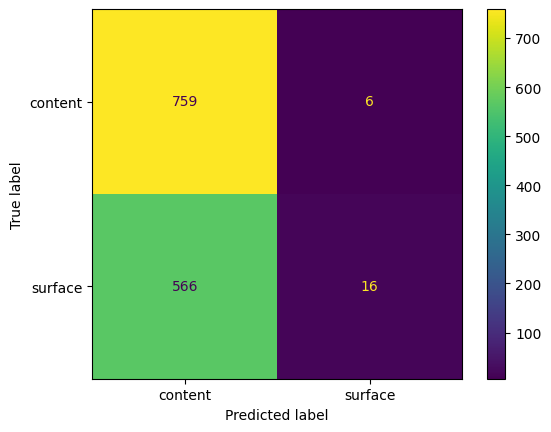

In [15]:
cm = confusion_matrix(actual_rev_types[:len(descriptive_prompts)//shortening_factor], descriptive_preds, labels=["content", "surface"])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["content", "surface"]
)
disp.plot();

Using a threshold of 0 (i.e. predicting “content” only if the “substantial” logprobs were greater than the “superficial” logprobs), GPT-2 demonstrated an overwhelming bias towards “content” revisions rather than “surface revisions” (the latter being the case of the prior prompt). 

## Prompt-Engineered Prefix 2: Few-Shot Prompting

Our third prefix uses “few-shot prompting,” which prepends example classifications to the prefix to get the model familiar with the logical “pattern” of predictions. The prefix is written as follows:

"The following revision from: \<original1> to \<revision1> is substantive.
    
The following revision from: \<original2> to \<revision2> is superficial.
    
The following revision from: \<original3> to \<revision3> is substantive.
    
The following revision from: \<original4> to \<revision4> is superficial.
    
The following revision from: \<original5> to \<revision5> is "

In [16]:
few_shot_prompt = """
The following revision from: Having these types of vehicles is also not worth taking away people’s jobs and putting their do not have the technology to operate at a high level of safety in certain weather conditions.
to: Having these types of vehicles is also not worth putting people's lives at risk, especially for those who live in areas where it snows and rains a lot, because these vehicles do not have the technology to operate at a high level of safety in those weather conditions.
is substantive.

The following revision from: In light of recent events with the death of an Arizona woman at the hands of a self-driving Uber, many are unsure of what stance to take on the matter.
to: In light of recent events with the death of an Arizona woman at the hands of a self-driving Uber, many are conflicted on what stance to take on the matter.
is superficial.

The following revision from: On the other hand, the car companies, your lawyers and some other groups will love this idea to death.
to: On the other hand, the self- driving car companies, your lawyers and Google (they provide GPS) will love this idea to death."
is substantive.

The following revision from: There are many variables to consider when thinking about individuals using self-driving cars: the weather, other traditional cars and their drivers, and the possibility of inappropriate - or developmentally inappropriate person - like children, mistakenly getting behind the wheel.
to: There are many confounding variables to consider when thinking about individuals using self-driving cars: the weather, other traditional cars and their drivers, and the possibility of inappropriate - or developmentally-inappropriate persons - like children, mistakenly climbing behind the wheel.
is superficial.

The following revision from: {old_sentence}
to: {new_sentence} is 
"""

In [17]:
# Build the prefixes with few-shot prompting

few_shot_prompts = []
for i in range(len(data)):
    revision_type = data.loc[i, "revision_type"]
    if revision_type != "neither":
        old_sentence = data.loc[i, "original_sentence"]
        new_sentence = data.loc[i, "revised_sentence"]
        composite_stmts = few_shot_prompt.format(old_sentence=old_sentence, new_sentence=new_sentence)
        few_shot_prompts.append(composite_stmts)

In [18]:
# Get GPT-2's Predictions

shortening_factor = 1

few_shot_preds = []
few_shot_logprob_diffs = []

logprob_threshold = 0

for i in range(len(few_shot_prompts)//shortening_factor):
    few_shot_prompt = few_shot_prompts[i]

    content_logprobs = torch.stack(get_completion_logprobs(prefix=few_shot_prompt, completion="substantive")).to(torch_device)
    surface_logprobs = torch.stack(get_completion_logprobs(prefix=few_shot_prompt, completion="superficial")).to(torch_device)

    logprob_diff = (torch.sum(content_logprobs) - torch.sum(surface_logprobs)).item()
    few_shot_logprob_diffs.append(logprob_diff)

    if logprob_diff > logprob_threshold:
        few_shot_preds.append("content")
    else:
        few_shot_preds.append("surface")

## Performance Analysis

In [19]:
plot_roc(actual_rev_types[:len(prompts)//shortening_factor], few_shot_logprob_diffs, metric_label="Logprob Diff (GPT-2 Few-Shot)")

Area under the ROC Curve: 0.7372751162320599


Using few-shot prompting, GPT-2 shows significant improvement compared to using the baseline prompt and moderate improvement compared to providing contextual definitions of the classifications. Its ROC curve bulges significantly more towards the lower half of the false positive rates, indicating that the model’s false positive rate increases less even as the threshold is lowered to increase the true positive rate. Its true positive rate does still quickly decrease even for low thresholds, however. The AUC using few-shot prompting was 73.7%, representing a 7% increase from using “class definition” prompts and a 15.5% increase from using the baseline prompt. Thus, few-shot prompting was almost twice as effective as “class definition” prompting at improving the baseline, with a 15.5% increase compared to an 8.5% increase, respectively. Overall, then, few-shot prompting gives GPT-2 about a 73.7% chance to correctly score any given “content” revision higher than any given “surface” revision, which is reasonable performance. This suggests that giving the model example classifications ahead of time may indeed have gotten the model familiar with the logical “pattern” of predictions and better informed its weighting of the classification terms.

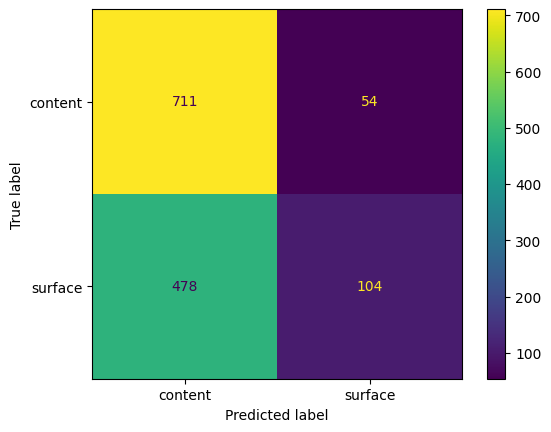

In [20]:
cm = confusion_matrix(actual_rev_types[:len(prompts)//shortening_factor], few_shot_preds, labels=["content", "surface"])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["content", "surface"]
)
disp.plot();

Using a threshold of 0 (i.e. predicting “content” only if the “substantial” logprobs were greater than the “superficial” logprobs), GPT-2 demonstrated a strong bias towards “content” revisions rather than “surface revisions”; however, it still made significantly more “surface” predictions overall than it did using the “class definition” prompt, which also had a strong bias towards “content” revisions and made almost no “surface” predictions.


---

## Using GEMMA-2B

## Baseline Prefix

Recall that our baseline prefix for comparison with GPT-2 is written as follows:

"The following revision from:\
\<original sentence>
to:\
\<revised sentence>\
"

We use this same prefix for consistency.


## Performance Analysis

We first show GPT-2's original performance on the baseline prompt to use for comparison.

### RECALL: GPT-2 Baseline Performance

In [21]:
plot_roc(actual_rev_types[:len(prompts)//shortening_factor], gpt2_logprob_diffs, metric_label="Logprob Diff (GPT-2 Baseline)")

Area under the ROC Curve: 0.5815466163555915


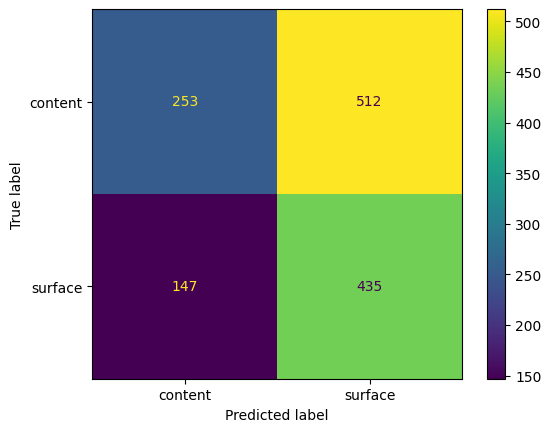

In [22]:
cm = confusion_matrix(actual_rev_types[:len(prompts)//shortening_factor], gpt2_preds, labels=["content", "surface"])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["content", "surface"]
)
disp.plot();

### GEMMA Performance

Although the code used to make GEMMA's predictions is provided below, it is not executed due to excessive runtime; the saved results from a prior execution are loaded instead.

In [23]:
# %pip install -U bitsandbytes
# %pip install accelerate
# %pip install -i https://pypi.org/simple/ bitsandbytes

In [24]:
# model_name = "/kaggle/input/gemma/transformers/2b/2"
    
# quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map=torch_device, quantization_config=quantization_config)

# tokenizer.decode([tokenizer.eos_token_id]);

In [25]:
# shortening_factor = 1

# gemma_preds = []
# gemma_logprob_diffs = []

# logprob_threshold = 0

# for i in range(len(prompts)//shortening_factor):
#     gemma_prompt = prompts[i]

#     content_logprobs = torch.stack(get_completion_logprobs(prefix=gemma_prompt, completion="is substantive")).to(torch_device)
#     surface_logprobs = torch.stack(get_completion_logprobs(prefix=gemma_prompt, completion="is superficial")).to(torch_device)

#     logprob_diff = (torch.sum(content_logprobs) - torch.sum(surface_logprobs)).item()
#     gemma_logprob_diffs.append(logprob_diff)

#     if logprob_diff > logprob_threshold:
#         gemma_preds.append("content")
#     else:
#         gemma_preds.append("surface")

In [26]:
with open("/kaggle/input/gemma-data/gemma_data.json", "r") as file:
    gemma_data = json.load(file)

Perhaps surprisingly, GEMMA-2B performs worse than GPT-2 on the baseline prompt, and worse even than a random classifier. Its ROC curve closely follows the random baseline and even drops below it in some places, resulting in an AUC of 0.47. This may be because GEMMA-2B uses subword tokenization while GPT-2 generally uses whole-word tokenization, increasing the number of logprobs calculated for GEMMA-2B's classifications and possibly changing how GEMMA-2B would predict the completion. 

In [27]:
plot_roc(actual_rev_types[:len(prompts)], gemma_data["logprob_diffs"], metric_label="Logprob Diff (GEMMA-2B Baseline)")

Area under the ROC Curve: 0.47061294162567663


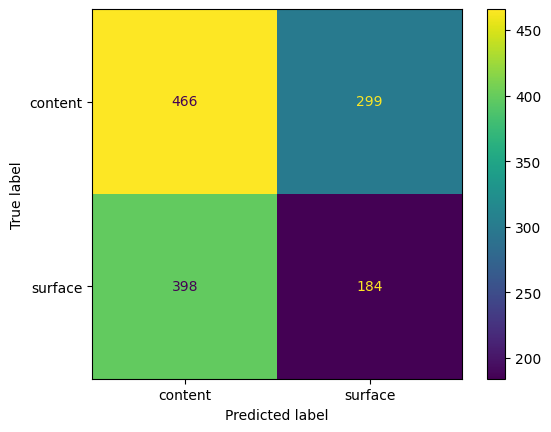

In [28]:
cm = confusion_matrix(actual_rev_types[:len(prompts)], gemma_data["predictions"], labels=["content", "surface"])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["content", "surface"]
)
disp.plot();

Using a threshold of 0 (i.e. predicting “content” only if the “substantial” logprobs were greater than the “superficial” logprobs), GEMMA demonstrated a strong bias towards “content” revisions. Interestingly, its confusion matrix horizontally mirrors that of GPT-2’s on the baseline prompt—but unlike GPT-2, its performance barely improves at all no matter what threshold is chosen.

---

# The Sentence-Similarity Approach

## The model: mpnet-base-v2
We will use mpnet-base-v2 as our model for the similarity score approach. mpnet-base-v2 is an SBERT model derived from the BERT architecture. BERT models compute sentence-level embeddings by pooling token-level embeddings, allowing them to capture the semantic meaning of sentences beyond that of individual tokens. The “S” in SBERT, which stands for “Siamese,” refers to the concept of “Siamese,” or “conjoined,” twins, which in turn alludes to the way in which SBERT models are trained. SBERT models are trained on “conjoined” pairs of sentences, using a loss function that quantifies a model’s “surprisal” on the type of relationship between those sentences. Thus, SBERT models use the sentence-level embeddings of the BERT architecture and a “conjoined” training approach to learn to output high similarity scores for semantically similar sentences ([Briggs](https://www.pinecone.io/learn/series/nlp/sentence-embeddings/)). mpnet-base-v2 is a strong general-purpose model described as “provid[ing] the best quality” on the [SBERT website](https://www.sbert.net/docs/pretrained_models.html), so we use it here.

Our classification algorithm roughly adopts the following approach:
* Compute the similarity score of the original sentence and the revision.
* Invert the similarity score with a negative sign to measure “difference.”
* If this “difference” is greater than a certain threshold, predict “content”; otherwise, predict “surface.”

In [29]:
model = SentenceTransformer("all-mpnet-base-v2").to(torch_device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

We will build lists of the original sentences and their corresponding revised sentences to pass directly to the sentence transformer.

In [30]:
old_sentences = []
new_sentences = []
actual_rev_types = []

for i in range(len(data)):
    revision_type = data.loc[i, "revision_type"]
    if revision_type != "neither":
        old_sentence = str(data.loc[i, "original_sentence"])
        old_sentences.append(old_sentence)
        new_sentence = str(data.loc[i, "revised_sentence"])
        new_sentences.append(new_sentence)
        actual_rev_types.append(revision_type)

In [31]:
# Make the predictions based on the sentences' cosine similarities

shortening_factor = 1
sbert_preds = []
diff_scores = []

diff_threshold = -0.1871

for i in range(len(old_sentences)//shortening_factor):
    
    # Cosine-similarity code adapted from: https://www.sbert.net/docs/usage/semantic_textual_similarity.html
    with torch.no_grad():
        # Compute embeddings
        original_embed = model.encode(old_sentences[i], convert_to_tensor=True, show_progress_bar=False).to(torch_device)
        revision_embed = model.encode(new_sentences[i], convert_to_tensor=True, show_progress_bar=False).to(torch_device)

        # Compute cosine-similarities
        cos_similarity = util.cos_sim(original_embed, revision_embed)
        diff_score = -cos_similarity[0].item()
        diff_scores.append(diff_score)

        if diff_score > diff_threshold:
            sbert_preds.append("content")
        else:
            sbert_preds.append("surface")

## Performance Analysis

In [32]:
plot_roc(actual_rev_types[:len(old_sentences)//shortening_factor], diff_scores, metric_label="Semantic Diff (Sentence Transformer)")

Area under the ROC Curve: 0.9359566965388675


The sentence transformer performs far better on the classification task than any of the prior approaches, maintaining a >0.7 true positive rate for all thresholds—even those that enable a false positive rate of near-zero. The model’s AUC was 93.6%, indicating that it has a 93.6% chance of correctly scoring any given “content” revision higher than any given “surface” revision. 


The confusion matrix for a near-zero false positive rate is shown below; the model maintains a relatively high true positive rate even so.

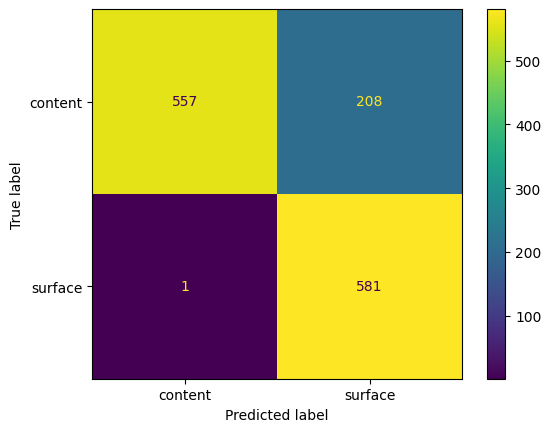

In [33]:
cm = confusion_matrix(actual_rev_types[:len(old_sentences)//shortening_factor], sbert_preds, labels=["content", "surface"])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["content", "surface"]
)
disp.plot();

---

# Final Results

Provided below are the AUC values for all approaches considered in this report. These values correspond to the approaches’ likelihoods of correctly scoring any given “content” revision higher than any given “surface” revision.

| Classification Approach | Scoring Method | AUC |
| ----------------------- | -------------- | --- |
| GPT-2 (baseline prompt) | Logprob Diff | 0.582 |
| GPT-2 (class definition prompt) | Logprob Diff | 0.667 |
| GPT-2 (few-shot prompt) | Logprob Diff | 0.737 |
| GEMMA-2B (baseline prompt) | Logprob Diff | 0.47 |
| Sentence Transformer | Cosine Similarity | 0.936 |

# Conclusion

In order from least effective to most effective, the models’ performance on the binary revision classification task was as follows:

* GEMMA-2B (baseline prompt)
* GPT-2 (baseline prompt)
* GPT-2 (class definition prompt)
* GPT-2 (few-shot prompt)
* Sentence Transformer (measuring cosine similarity of revision)

## Prompt Engineering on GPT-2
GPT-2’s performance on the various prompts in this report demonstrates that prompt engineering can improve model performance on classification tasks, in this case by defining classes ahead of time and utilizing few shot prompting.

## GEMMA-2B’s Performance
On the other hand, GEMMA-2B’s poor performance on the classification task demonstrates that one cannot assume identical prompting works equally well across language models, even if more “advanced” (larger-parameter) models are used. 

## Sentence Transformer Cosine Similarity
Classification using cosine similarity was demonstrated to be more effective and interpretable than using the difference of logprobs. Calculating the difference of logprobs is a more computationally-intensive and convoluted process, while cosine similarity can be computed and interpreted far more easily. The sentence transformer's high AUC score demonstrates its high rate of success in computing lower cosine similarities for content-level revisions than for surface-level revisions.


---

# Limitations

## Dataset Limitations
The ArgRewrite corpus only contains essays written for a single argumentative prompt concerning self-driving cars. Thus, the results discussed in this notebook may not fully represent the models’ general classification abilities for essays of other subjects.

## Lack of Prompt Engineering on GEMMA-2b
Due to limitations of time and computational resources, we were unable to use longer prompts when obtaining GEMMA-2b’s classifications. Hence, we are only able to compare GPT-2’s and GEMMA-2b’s performance on the baseline prompt without some of the additional prompt engineering done on GPT-2. It is possible that GEMMA-2b’s performance would have improved to be on par with that of GPT-2, especially with few-shot prompting, but we lack the computational power necessary to conduct such an experiment.

## Lack of True Chain-of-Thought Prompting And Computational Limitations
Successful chain-of-thought prompting requires language models to coherently generate intermediate reasoning of some sort to allow them to explicitly condition their final answer on that intermediate generation. More advanced instruction-tuned models are generally required to generate this kind of reasoning with any reliability. To keep this report self-contained, these models were not employed, as their usage would require access to processing power outside that which is freely available on Kaggle. Instead, we prompted GPT-2 with “prepackaged reasoning,” which provided definitional explanations for the completion terms “substantive” and “superficial.” This approach is far less adaptive than chain-of-thought prompting, as it only adds a small amount of boilerplate reasoning to the prompt without adapting to the particulars of the sentences under evaluation. Hence, this report does not provide any workflows to test more advanced models’ chain-of-thought capabilities.

## Using Automation Responsibly
This report provides a possible workflow for automatically evaluating students’ revisions, which is not always desirable in every situation. The binary “content”/”surface” categorization lacks nuance and does not provide students with the individual feedback they might need to improve their revision, regardless of writing level. While the quantitative measures used to make the binary classification provide a slightly more nuanced continuous measure, they nonetheless reduce the complex process of revision to a single number that offers little direction for improvement. More complex, personalized feedback is required for students to grow as writers and revisers. Hence, our evaluation methodology is not intended to be used in educational contexts. It is intended to grant insights into broad patterns of revisions, rather than how to personally improve one’s own writing.

---

# Future Work

## Essay-Level Evaluation

This report only analyzes sentence-level revision classification, but could potentially be expanded to generate and analyze essay-level revision scores.

## Prompting Modern LLMs

Modern LLMs are much more “competent generalists” on NLP tasks than any model running in a self-contained Kaggle notebook, so further studies into the effectiveness of the “completion approach” might use the APIs of LLMs like GPT-4 or LLAMA-3 to get a better idea of how the very best models could perform on the classification task. These models more reliably generate intermediate reasoning as well, which would allow for additional experimentation with “chain-of-thought” prompting—possibly by prompting models to identify parts of a revision that would lead them to conclude a revision is “surface-level” or “content-level.”

## Fine-Tuning

Due to time constraints, this report’s analysis centers on existing models without fine-tuning them for the specific task of revision classification. Future studies might focus on whether or how much fine-tuning can improve models’ performance on this task.

## Evaluating Performance on Revision Subcategories

The dataset of revisions used in this report included finer-grained revision categories not considered in our analysis. Our evaluation could benefit from additional, finer-grained analysis of the revision subclasses our models fail at most. With this information in mind, the models could be fine-tuned in an attempt to improve the their performance on those specific subclasses. This report does not use fine-tuning due to time constraints; however, the evaluations provided in this report provide a possible workflow which can be expanded to measure a fine-tuned model’s performance on revision subclasses. Thus, the process of fine-tuning and evaluating performance on revision subclasses will be left to future work.

---

# Appendix

## Data Wrangling

In [34]:
import requests
import zipfile
import io
from pathlib import Path
import re
import warnings

### Download Dataset

The [ArgRewrite dataset](https://argrewrite.cs.pitt.edu/#corpus) was shared by the original authors under GNU GPLv3. Therefore, we have also released our wrangled version under the same license, which is accessible on Kaggle [here](https://www.kaggle.com/datasets/nghtctrl/argrewrite-v-2-corpus).

In [35]:
corpus_url = "https://argrewrite.cs.pitt.edu/corpus/ArgRewrite.V2.zip"
corpus_path = "argrewrite-v-2-corpus"
response = requests.get(corpus_url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(corpus_path)

### Open annotated essay files

In [36]:
annotations_path = Path(corpus_path) / "annotations"
xlsx_files = list(annotations_path.glob("**/12/*.xlsx"))

print(f"There are {len(xlsx_files)} xlsx files in the corpus.")

There are 87 xlsx files in the corpus.


### Extract relevant data from .xlsx files

In [37]:
%pip install -U openpyxl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [38]:
def get_ids(prefix, filename):
    """Function used to retrieve writer IDs"""
    regex = prefix + "(\d+)"
    return re.search(regex, filename).group(1)


old_draft_dfs = []
new_draft_dfs = []

for xlsx_file in xlsx_files:
    try:
        # Ignore all of the openpyxl incompatibility warnings.
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=UserWarning,
                module=re.escape("openpyxl.styles.stylesheet"),
            )
            with open(xlsx_file, "rb") as f:
                # Open each of the "Old Draft" and "New Draft" sheets
                old_draft_sheet = pd.read_excel(f, sheet_name="Old Draft")
                new_draft_sheet = pd.read_excel(f, sheet_name="New Draft")
                
                # Extract the writer IDs from the file path
                writer_id = get_ids("Annotation_2018argrewrite_", str(f))
                
                old_draft_df = pd.DataFrame(
                    {
                        "writer_id": writer_id,
                        "original_sentence_index": old_draft_sheet["Sentence Index"].astype(str),
                        "revised_sentence_index": old_draft_sheet["Aligned Index"].astype(str),
                        "original_sentence": old_draft_sheet["Sentence Content"],
                        "revision_purpose": old_draft_sheet["Revision Purpose Level 0"],
                        "revision_operation": old_draft_sheet["Revision Operation Level 0"],
                    }
                )
                old_draft_dfs.append(old_draft_df)

                new_draft_df = pd.DataFrame(
                    {
                        "writer_id": writer_id,
                        "original_sentence_index": new_draft_sheet["Aligned Index"].astype(str),
                        "revised_sentence_index": new_draft_sheet["Sentence Index"].astype(str),
                        "revised_sentence": new_draft_sheet["Sentence Content"],
                        "revision_purpose": new_draft_sheet["Revision Purpose Level 0"],
                        "revision_operation": new_draft_sheet["Revision Operation Level 0"],
                    }
                )
                new_draft_dfs.append(new_draft_df)
    except ValueError as e:
        # Catch invalid files
        print(f"Error in {xlsx_file}: {e}")

old_draft_df = pd.concat(old_draft_dfs, ignore_index=True)
new_draft_df = pd.concat(new_draft_dfs, ignore_index=True)

Error in argrewrite-v-2-corpus/annotations/A/12/~$Annotation_2018argrewrite_1_NEW.txt.xlsx: Excel file format cannot be determined, you must specify an engine manually.


In [39]:
print(f"old_draft_df has {old_draft_df.shape[0]} rows.")
print(f"new_draft_df has {new_draft_df.shape[0]} rows.")

old_draft_df has 2130 rows.
new_draft_df has 2377 rows.


### Reformat multiple revisions from 1 source sentence to only take up 1 row

In [40]:
# Find rows where revision_sentence was indicated to be revised from 2+ original_sentences, indicated by ',' separator
multiple_original_indices = new_draft_df["original_sentence_index"].str.contains(
    ",", na=False
)

# Create dataframe storing rows of new_draft_df with sentences revised from 2+ multiple original_sentences
combined_sentences_df = new_draft_df.loc[multiple_original_indices]

# Each item in the list will be a string of sentences that were combined in the new_draft_df
combined_sentence_strings = []

# For each case where sentences were combined:
for row in combined_sentences_df.iloc:
    writer_id = row["writer_id"]  # Get id of writer who combined sentences
    original_index_group = row["original_sentence_index"].split(
        ","
    )  # Get indices of writer's combined sentences
    source_sentences = ""  # Temp string for sentences that were combined

    # For each of the indices of the writer's combined sentences:
    for original_index in original_index_group:
        # Determine row of next combined sentence via id of combining writer and index of next combined sentence
        to_combine = (old_draft_df["writer_id"] == writer_id) & (
            old_draft_df["original_sentence_index"] == original_index
        )
        # Add the row's sentence to string storing sentences that were combined
        source_sentences += (
            " " + old_draft_df.loc[to_combine]["original_sentence"].values[0]
        )

    combined_sentence_strings.append(source_sentences)

# For rows with multiple values in original_sentence_index, force original_sentence_index to only the first index listed
new_draft_df.loc[multiple_original_indices, "original_sentence_index"] = (
    new_draft_df.loc[multiple_original_indices, "original_sentence_index"]
    .str.split(",")
    .str[0]
)

print(f"old_draft_df has {old_draft_df.shape[0]} rows.")
print(f"new_draft_df has {new_draft_df.shape[0]} rows.")

old_draft_df has 2130 rows.
new_draft_df has 2377 rows.


### Join the original and revised datasets into one dataframe

In [41]:
# Do a full outer join based on the sentence indexes
sentence_pair_df = new_draft_df.merge(
    old_draft_df[["writer_id", "original_sentence", "original_sentence_index"]],
    how="outer",
    left_on=["writer_id", "original_sentence_index"],
    right_on=["writer_id", "original_sentence_index"],
)

print(f"sentence_pair_df has {sentence_pair_df.shape[0]} rows.")

sentence_pair_df has 2707 rows.


In [42]:
# Do the following for all cases of combined_sentences:
for i in range(len(combined_sentences_df["writer_id"])):
    writer_id = combined_sentences_df["writer_id"].iloc[
        i
    ]  # Get id of writer who combined sentences
    revised_sentence_id = combined_sentences_df["revised_sentence_index"].iloc[
        i
    ]  # Get id of revised combined sentence

    # Get row of sentence revised by combining old sentences
    revised_row = (sentence_pair_df["writer_id"] == writer_id) & (
        sentence_pair_df["revised_sentence_index"] == revised_sentence_id
    )
    # Retrieve string of the old sentences that were combined
    revised_sentence = combined_sentence_strings[i]

    # Set original_sentence in revised sentence's row to be the sentences the revised sentence combined
    sentence_pair_df.loc[revised_row, "original_sentence"] = revised_sentence

    # Debug message printing each modified row. The revised sentence should share content with the source sentences.
    print(
        "Source sentences:",
        sentence_pair_df.loc[revised_row]["original_sentence"].values[0],
        "\nRevised sentence:",
        sentence_pair_df.loc[revised_row]["revised_sentence"].values[0],
    )
    print()

Source sentences:  Self-Driving cars can eliminate that mundane job which we need to do compute on daily basis. Such technology can help reduce the effort for taxi drivers for whom this more like a job than a passion or a choice. 
Revised sentence: Self-Driving cars can eliminate that mundane task of driving and can specifically help reduce the effort for taxi drivers for who pursue this as a job rather than a passion or a personal choice.

Source sentences:  Something as simple as the replacement of chalk and slates with pencil and paper in schoolhouses was a shift that created public dialogue. It is not hard to understand the great debate in our society today around something as monumental as self-driving cars taking the streets. 
Revised sentence: Something as simple as the replacement of chalk and slate with pencil and paper in schoolhouses created public dialogue, so it is not hard to understand the great debate in our society today around something as monumental as self-driving c

In [43]:
# Get the number of each revision subtypes
sentence_pair_df["revision_purpose"].value_counts()

revision_purpose
Word-Usage/Clarity                                           454
General Content Development                                  263
Warrant/Reasoning/Backing                                    175
Conventions/Grammar/Spelling                                 126
Claims/Ideas                                                 114
Evidence                                                      74
Organization                                                  55
Precision                                                     50
Rebuttal/Reservation                                          14
Warrant/Reasoning/Backing,General Content Development          7
General Content Development,Warrant/Reasoning/Backing          3
General Content Development,Claims/Ideas                       1
Warrant/Reasoning/Backing,Claims/Ideas                         1
Organization,General Content Development                       1
Word-Usage/Clarity,General Content Development                 1
Word-Usa

### Change granular revision categories to broader "content" and "surface" categories

In [44]:
def classify_purpose(x):
    """This function converts revision subtypes as either 'content', 'surface', or 'neither'"""
    if isinstance(x, str):
        # Simple hack to match the subwords; however, there might be a better way to do this
        if any(
            word in x
            for word in ["Clai", "Warr", "Evid", "Rebu", "Prec", "Cont", "Orga"]
        ):
            return "content"
        else:
            return "surface"
    else:
        return "neither"


# Insert the newly converted revision types into the sentence pairs dataset
revision_type = sentence_pair_df["revision_purpose"].apply(classify_purpose)
assert len(revision_type) == sentence_pair_df.shape[0]
sentence_pair_df["revision_type"] = revision_type

sentence_pair_df["revision_type"].value_counts()

revision_type
neither    1360
content     765
surface     582
Name: count, dtype: int64

### Save as .csv file

In [45]:
sentence_pair_df.to_csv("sentence_pairs.csv", index=False)